# Calibration Model 01: Bayesovská kalibrace (Bayes Calibration)

### Počet kalibrovaných parametrů: 1

### Kalibrační framework

* Zarovnat časové osy

* Definovat dynamický model

* Zavést prior na parametry

* Zavést prior na šum

* Přidat modelovou diskrepanci

* MCMC sampling

* Posterior predictive kontrola

In [1]:
# Instalace potřebných knihoven
#%pip install pandas
#%pip install numpy
#%pip install seaborn matplotlib
#%pip install pymc
#%pip install arviz
#%pip install ipywidgets

In [2]:
# Import potřebných knihoven
import pandas as pd
import numpy as np

import pymc as pm
import arviz as az

import seaborn as sns
import matplotlib.pyplot as plt

### Vstupní data

In [3]:
### Načtení časosběru

# Soubor je načten a přiřazen do proměnné ‚df‘
other_path = '../../data/02_DetermModel/model_data_real.csv'
df = pd.read_csv(other_path, header=0)
df = df[['id', 'x', 'y', 'z', 'dist', 'total_time']]
df

,id,x,y,z,dist,total_time
0,1,220,95,0,2731,41
1,2,220,252,0,2596,36
2,4,220,690,0,2350,37
3,6,220,1190,0,1804,35
4,9,220,1940,0,1454,45
...,...,...,...,...,...,...
101,125,220,1565,750,1022,32
102,128,220,2315,750,684,33
103,129,220,2565,750,726,33
104,133,220,3565,750,1417,39


### Parameter pro kalibraci
* průměrná rychlost pohybu TCP robota

In [4]:
t = df["total_time"].values
# průměrná rychlost pohybu TCP robota
y_real = df["dist"].values / df["total_time"].values

In [5]:
y_real

array([ 66.6097561 ,  72.11111111,  63.51351351,  51.54285714,
        32.31111111,  41.44117647,  41.41176471,  45.3125    ,
        32.59574468,  48.47058824,  45.32142857,  57.08695652,
        54.80851064,  60.04545455,  62.02272727,  64.45454545,
        67.27272727,  67.39130435,  70.69565217,  74.2826087 ,
        72.55769231,  80.87755102, 123.30555556,  69.52631579,
        58.72093023,  56.80952381,  61.35897436,  55.13636364,
        60.56097561,  58.27272727,  51.26923077,  60.56521739,
        67.97674419,  70.39130435,  64.37735849,  76.4893617 ,
        82.30434783,  84.74468085,  58.73684211,  50.05263158,
        39.79069767,  40.42105263,  35.51282051,  27.52173913,
        27.60465116,  31.32432432,  26.31111111,  39.34375   ,
        38.19444444,  41.21621622,  49.94117647,  40.17021277,
        58.08333333,  63.97222222,  56.53333333,  40.46428571,
        55.15789474,  49.31578947,  48.85294118,  42.91176471,
        23.59259259,  31.09375   ,  29.93939394,  53.08

### Definice hybridního modelu

In [6]:
def hybrid_model(t, theta1, theta2):
    # příklad exponenciálního rozpadu
    return theta1 * np.exp(-theta2 * t)

### Bayesovská kalibrace s modelovou diskrepancí

In [7]:
with pm.Model() as model_gp:

    # -------------------
    # 1) Parametry modelu
    # -------------------

    theta1 = pm.Normal("theta1", mu=1.0, sigma=5)
    theta2 = pm.Normal("theta2", mu=0.1, sigma=1)

    sigma = pm.HalfNormal("sigma", 1)

    # -------------------
    # 2) Deterministický model
    # -------------------

    mu_model = hybrid_model(t, theta1, theta2)

    # -------------------
    # 3) GP diskrepance
    # -------------------

    length_scale = pm.Gamma("length_scale", alpha=2, beta=1)
    variance_scale = pm.HalfNormal("variance_scale", 1)

    cov = variance_scale**2 * pm.gp.cov.ExpQuad(1, length_scale)

    gp = pm.gp.Latent(cov_func=cov)

    delta = gp.prior("delta", X=t[:, None])

    # -------------------
    # 4) Likelihood
    # -------------------

    y = pm.Normal(
        "y",
        mu=mu_model + delta,
        sigma=sigma,
        observed=y_real
    )

    trace_gp = pm.sample(
        draws=2000,
        tune=1500,
        target_accept=0.95
    )

Initializing NUTS using jitter+adapt_diag...
c:\Users\usman\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytensor\link\c\cmodule.py:2986: UserWarning: PyTensor could not link to a BLAS installation. Operations that might benefit from BLAS will be severely degraded.
This usually happens when PyTensor is installed via pip. We recommend it be installed via conda/mamba/pixi instead.
Alternatively, you can use an experimental backend such as Numba or JAX that perform their own BLAS optimizations, by setting `pytensor.config.mode == 'NUMBA'` or passing `mode='NUMBA'` when compiling a PyTensor function.
For more options and details see https://pytensor.readthedocs.io/en/latest/troubleshooting.html#how-do-i-configure-test-my-blas-library
  warnings.warn(
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2, sigma, length_scale, variance_scale, delta_rotated_]


Output()

Sampling 4 chains for 1_500 tune and 2_000 draw iterations (6_000 + 8_000 draws total) took 201 seconds.


### Diagnostika

array([[<Axes: title={'center': 'theta1'}>,
        <Axes: title={'center': 'theta1'}>],
       [<Axes: title={'center': 'theta2'}>,
        <Axes: title={'center': 'theta2'}>],
       [<Axes: title={'center': 'delta_rotated_'}>,
        <Axes: title={'center': 'delta_rotated_'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>],
       [<Axes: title={'center': 'length_scale'}>,
        <Axes: title={'center': 'length_scale'}>],
       [<Axes: title={'center': 'variance_scale'}>,
        <Axes: title={'center': 'variance_scale'}>],
       [<Axes: title={'center': 'delta'}>,
        <Axes: title={'center': 'delta'}>]], dtype=object)

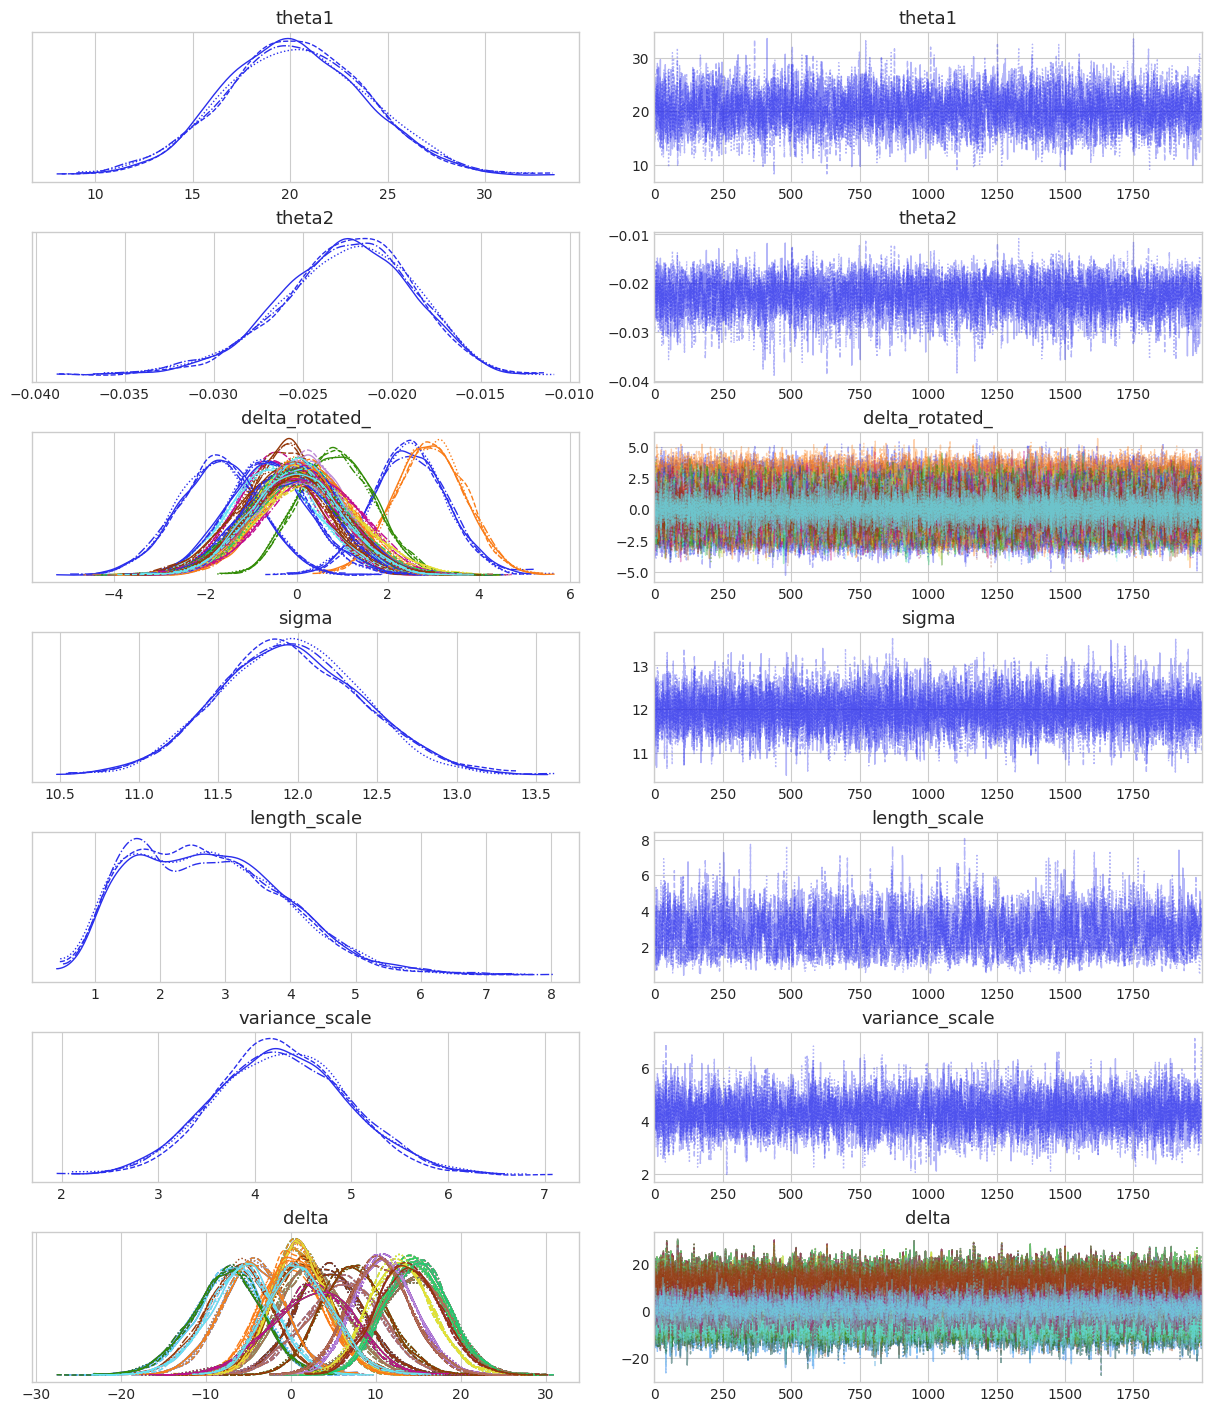

In [8]:
az.summary(trace_gp)

az.style.use("arviz-whitegrid")

plt.rcParams.update({
    "figure.figsize": (12, 8),
    "font.size": 12,
    "axes.titlesize": 13,
    "axes.labelsize": 11,
    "legend.fontsize": 10,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "lines.linewidth": 1.0,
})

az.plot_trace(trace_gp)

### Posterior predictive kontrola

In [9]:
with model_gp:
    trace_gp.extend(
        pm.sample_posterior_predictive(trace_gp)
    )

Sampling: [y]


Output()

C:\Users\usman\AppData\Local\Temp\ipykernel_7104\1478371250.py:15: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


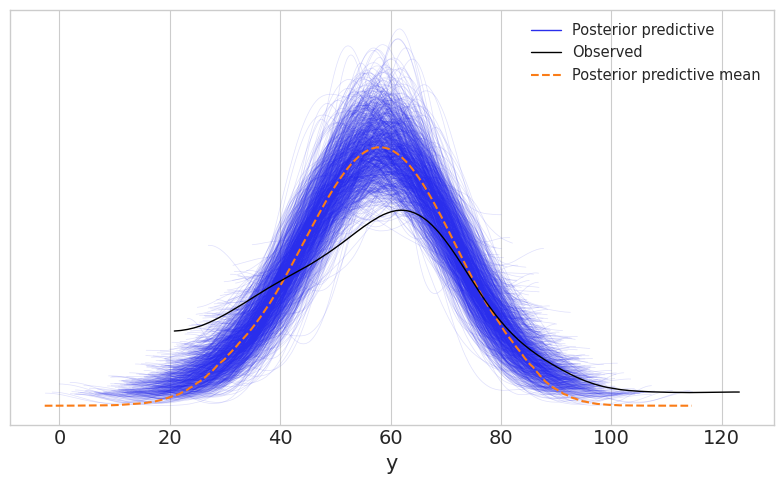

In [10]:
az.style.use("arviz-whitegrid")

fig, ax = plt.subplots(figsize=(8,5))

az.plot_ppc(
    trace_gp,
    num_pp_samples=1000,     # don't plot all draws!
    kind="kde",
    mean=True,
    observed=True,
    alpha=0.15,
    ax=ax
)

plt.tight_layout()

### Souhrnná statistika posteriorní prediktivní distribuce modelu

In [11]:
summary_df = az.summary(trace_gp, group="posterior_predictive")
summary_df

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
y[0],60.930,12.184,38.298,84.349,0.134,0.095,8239.0,7716.0,1.0
y[1],59.617,12.479,35.799,83.321,0.145,0.099,7421.0,8040.0,1.0
y[2],60.886,12.130,36.930,82.844,0.143,0.099,7233.0,7549.0,1.0
y[3],55.254,12.208,32.054,77.909,0.137,0.098,7979.0,7808.0,1.0
y[4],56.277,12.107,34.628,79.993,0.138,0.099,7696.0,7192.0,1.0
...,...,...,...,...,...,...,...,...,...
y[101],42.418,12.270,19.810,65.546,0.137,0.096,8035.0,7247.0,1.0
y[102],44.363,12.573,20.865,68.111,0.148,0.096,7261.0,7885.0,1.0
y[103],44.659,12.451,21.674,68.345,0.145,0.096,7386.0,7499.0,1.0
y[104],61.928,12.173,38.339,84.037,0.135,0.101,8130.0,7590.0,1.0


### Export datové sady do formátu CSV

In [12]:
summary_df.to_csv("../../data/05_Calibration/posterior_predictive_summary_one.csv", index=False)

In [13]:
az.to_netcdf(trace_gp, "../../data/05_Calibration/posterior_trace_one.nc")

'../../data/05_Calibration/posterior_trace_one.nc'

### Autor / Organizace / Datum

Vjačeslav Usmanov, ČVUT v Praze, Fakulta stavební

###### Přehled změn


|  Datum (YYYY-MM-DD) |  Verze | Autor změny  |  Popis změny |
|---|---|---|---|
| 2026-01-30 | 1.1 | Vjačeslav Usmanov| added CM_01_BayesCalibration_one.ipynb |
| 2026-02-17 | 1.2 | Vjačeslav Usmanov| changed CM_01_BayesCalibration_one.ipynb |